In [1]:
from datetime import datetime
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from konlpy.tag import Mecab
mecab = Mecab()

#import lightgbm as lgb

import tensorflow as tf
import keras

Using TensorFlow backend.


In [2]:
pd.options.display.max_rows = 1000

In [3]:
df = pd.read_csv('./data/train.csv')

In [206]:
result_txt = """분         57552
고객         9985
개인         5210
사업자        3527
이          1706
대상         1540
당신         1380
직원          861
VIP         569
자           457
분도          323
전문직         309
신용자         194
외국인         125
본인          118
임직원         115
부모          102
회계사          81
귀하           74
투자자          72
분과           63"""
print([x.split()[0] for x in result_txt.split('\n')])

['분', '고객', '개인', '사업자', '이', '대상', '당신', '직원', 'VIP', '자', '분도', '전문직', '신용자', '외국인', '본인', '임직원', '부모', '회계사', '귀하', '투자자', '분과']


In [4]:
import re

num_re = re.compile('([0-9X]+[\-\.]+[\-.0-9X]+|[0-9X]+[.0-9X]+\%|[0-9X]+[년월일천만억원]+)')
#num_re = re.compile('[0-9X]+[년월일천만억원]+|[0-9X]+[\-\.]+[\-.0-9X]+')
fon_re = re.compile('[0-9X]{2,4}-[0-9Xx]{2,4}-[0-9Xx]{4}')

deny_re = re.compile("무료거부|무료수신거부")


In [5]:
def parse_sentence(sentence):
    ret = []
    nouns = []
    condition = False
    
    if sentence[:4] == '(광고)':
        nouns.append('(광고)')
        sentence = sentence[4:]
        
    prev_wordpos = ('', '')
    ss = ''
    for word in mecab.pos(sentence):
        # 계시다면 등에서 다면이 N으로 파싱됨
        if word[1][:1] == 'S' and word[0][:1] not in '()':
            # 숫자나 X등
            if ss == '' and word[1] == 'SF':
                # 점으로 시작하는 경우는 무시
                pass
            else:
                ss += word[0]
        elif len(ss) > 0:
            # 숫자 뒤에 명사가 와서 의미를 만드는 경우 : 1월, 20일, 1만원 등
            #if word[1][:1] == 'N':
            #    ss += word[0]
            nouns.append(re.sub('[0-9.X]+', 'X', ss))
            ss = ''
            
        if prev_wordpos[1][-3:] == 'ETM' and word[0] in ['분','고객','개인','사업자','이','대상','당신','직원','VIP', '자','분도','전문직','신용자','외국인','본인','임직원','부모','회계사','귀하','투자자','분과']:
            condition = True
            
        if word[1][:1] == 'M':
            nouns.append(word[0])
        elif word[1][:1] == 'N':
            if word[0][:2] in ('경우', '필요', '라면', '다면'): # 경우, 필요 단어 등장 시 조건절로 판단
                condition = True
            elif word[0] == '시' and prev_wordpos[1][:1] == 'N':  # 넣으나 마나.. 왜 그렇지?
                condition = True
            else:
                nouns.append(word[0])
        # 도 : 여도, 라도
        # 면 : 라면, 면
        elif word[1] == 'EC':
            if word[0][-1:] in ('면', '도') or word[0][-2:] in ('도록'):
                condition = True
        elif word[1][:1] == 'V':
            nouns.append(word[0])
        elif word[1][-2:] in ('EF'): # and word[0][-1:] in ['요', '다']:
            # nouns가 꼭 명사를 뜻하는 게 아니고 특색있는 키워드 모두를 포함
            nouns.append(word[0])
            ret.append([word[0], condition, nouns])
            nouns = []
            condition = False
        prev_wordpos = word
    if len(nouns) > 0:
        #nouns.append(word[0])
        ret.append([word[0], condition, nouns])
    
    
#     # 가장 많은 단어를 가진 조건절만 남기고 나머지는 일반문장으로 원복
#     max_len, selected = 0, -1
#     for idx, item in enumerate(ret):
#         if item[1] == True and len(item[2]) > max_len:
#             selected, max_len = idx, len(item[2])
#         ret[idx][1] = False
#     if selected >= 0:
#         ret[selected][1] = True
    return ret

In [6]:
smishings = []
normals = []
idx = 0
for idx, item in df.iterrows():
    #print(item.text)
    splited = parse_sentence(item.text)
    splited.append(item.id)
    #splited = m.parse(item.text).split()
    if item.smishing == 1:
        smishings.append(splited)
    else:
        normals.append(splited)
    if idx % 100000 == 0:
        print(datetime.now(), idx)
    idx += 1
#     if idx > 20000:
#         break

2019-12-31 08:23:08.775402 0
2019-12-31 08:23:53.391903 100000
2019-12-31 08:24:45.249162 200000


In [7]:
class wordCounter():
    def __init__(self):
        self.word_bank = {}
    
    def add_bucket(self, bucket_name):
        self.word_bank[bucket_name] = {}
        
    def add_list(self, bucket_name, word_list:[]):
        bucket = self.word_bank[bucket_name]
        for keyword in word_list:
            if keyword in bucket:
                bucket[keyword] += 1
            else:
                bucket[keyword] = 1
                
    def get_counts(self, bucket_name):
        return self.word_bank[bucket_name]

In [8]:
wc = wordCounter()
wc.add_bucket('conditioned')
wc.add_bucket('general')

for normal in normals:
    for item in normal[:-1]:
        if item[1] == True:
            wc.add_list('conditioned', item[2])
        else:
            wc.add_list('general', item[2])

for smishing in smishings:
    for item in smishing[:-1]:
        if item[1] == True:
            wc.add_list('conditioned', item[2])
        else:
            wc.add_list('general', item[2])

In [9]:
conditioned_df = pd.Series(wc.get_counts('conditioned'))
general_df = pd.Series(wc.get_counts('general'))

# 글자가 2개 이상인 것만 모아보자
#conditioned_df = conditioned_df[conditioned_df.index.map(len) > 1]
#general_df = general_df[general_df.index.map(len) > 1]

In [10]:
general_dic = general_df[general_df > 1].sort_values(ascending=False)
general_dic = general_dic.reset_index()['index'].to_dict()
general_vocab = {general_dic.get(k):k for k in general_dic}

In [11]:
conditioned_dic = conditioned_df[conditioned_df > 1].sort_values(ascending=False)
conditioned_dic = conditioned_dic.reset_index()['index'].to_dict()
conditioned_vocab = {conditioned_dic.get(k):k for k in conditioned_dic}

In [12]:
# smishing cases; length of vocab when it's out of vocab
tidf_conditioned = []
tidf_general = []

cond_vocabsize = len(conditioned_vocab)
gen_vocabsize = len(general_vocab)

print('size of vocab (conditioned, general):', cond_vocabsize, gen_vocabsize)
for msg in normals:
    tidf_conditioned.append([conditioned_vocab.get(x) if x in conditioned_vocab else cond_vocabsize for row in msg[:-1] if row[1] == True for x in row[2]])
    tidf_general.append([general_vocab.get(x) if x in general_vocab else gen_vocabsize for row in msg[:-1] if row[1] == False for x in row[2]])
for msg in smishings:
    tidf_conditioned.append([conditioned_vocab.get(x) if x in conditioned_vocab else cond_vocabsize for row in msg[:-1] if row[1] == True for x in row[2]])
    tidf_general.append([general_vocab.get(x) if x in general_vocab else gen_vocabsize for row in msg[:-1] if row[1] == False for x in row[2]])

size of vocab (conditioned, general): 17073 21749


In [14]:
# 문장 내 인식한 단어의 개수의 최대값 (문장의 길이가 길수록 크겠지..)
print('conditioned vector minimum size:', max(max([len(x) for x in tidf_conditioned]), max([len(x) for x in tidf_conditioned])))
print('general vector minimum size:', max(max([len(x) for x in tidf_general]), max([len(x) for x in tidf_general])))

conditioned vector minimum size: 380
general vector minimum size: 460


In [15]:
convec_size, genvec_size = 350, 470  # 15~20씩 여유

In [16]:
# 훈련용, 훈련검증용, 결과검증용 분리
tidf_conditioned = np.array(tidf_conditioned)
tidf_general = np.array(tidf_general)
tidf_label = np.array([1 if x >= len(normals) else 0 for x in range(tidf_conditioned.shape[0])])

In [17]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

class DataGenerator(keras.utils.Sequence):
    def __init__(self, tidf_cond_train, tidf_gen_train, tidf_label_train, normal_size=160, smishing_size=160, convec_size=350, genvec_size=470):
        self.convec_size = convec_size  # including 0 paddings
        self.genvec_size = genvec_size  # including 0 paddings
        self.tidf_cond_train_normal = pad_sequences(tidf_cond_train[tidf_label_train == 0], maxlen=self.convec_size, padding='pre')
        self.tidf_gen_train_normal = pad_sequences(tidf_gen_train[tidf_label_train == 0], maxlen=self.genvec_size, padding='pre')
        self.tidf_cond_train_smishing = pad_sequences(tidf_cond_train[tidf_label_train == 1], maxlen=self.convec_size, padding='pre')
        self.tidf_gen_train_smishing = pad_sequences(tidf_gen_train[tidf_label_train == 1], maxlen=self.genvec_size, padding='pre')
        self.normal_sample_size = normal_size
        self.smishing_sample_size = smishing_size
        self.num_batch = int(np.ceil(len(self.tidf_cond_train_normal) / (self.normal_sample_size + self.smishing_sample_size) / 10))
        print('num_batch:', self.num_batch)
    
    def __len__(self):
        return self.num_batch
    
    def __getitem__(self, index):
        # random sampling. ignore index
        normal_sampling = np.random.choice(len(self.tidf_cond_train_normal), self.normal_sample_size)
#         normal_cond_sample = pad_sequences(self.tidf_cond_train_normal[normal_sampling], maxlen=self.convec_size, padding='pre')
#         normal_gen_sample = pad_sequences(self.tidf_gen_train_normal[normal_sampling], maxlen=self.genvec_size, padding='pre')
        normal_cond_sample = self.tidf_cond_train_normal[normal_sampling]
        normal_gen_sample = self.tidf_gen_train_normal[normal_sampling]
        smishing_sampling = np.random.choice(len(self.tidf_cond_train_smishing), self.smishing_sample_size)
#         smishing_cond_sample = pad_sequences(self.tidf_cond_train_smishing[smishing_sampling], maxlen=self.convec_size, padding='pre')
#         smishing_gen_sample = pad_sequences(self.tidf_gen_train_smishing[smishing_sampling], maxlen=self.genvec_size, padding='pre')
        smishing_cond_sample = self.tidf_cond_train_smishing[smishing_sampling]
        smishing_gen_sample = self.tidf_gen_train_smishing[smishing_sampling]
        sample_cond_train = np.concatenate([normal_cond_sample, smishing_cond_sample])
        sample_gen_train = np.concatenate([normal_gen_sample, smishing_gen_sample])
        sample_label_train = [1 if x >= self.normal_sample_size else 0 for x in range(len(sample_cond_train))]
        return [sample_cond_train, sample_gen_train], sample_label_train

    def on_epoch_end(self):
        pass

In [18]:
TRAIN_RATIO, VALID_RATIO = 0.6, 0.8
np.random.seed(0)
split = np.random.rand(tidf_conditioned.shape[0])
tidf_cond_train = tidf_conditioned[split < TRAIN_RATIO]
tidf_cond_valid = tidf_conditioned[(split >= TRAIN_RATIO) & (split < VALID_RATIO)]
tidf_cond_test = tidf_conditioned[split >= VALID_RATIO]

tidf_gen_train = tidf_general[split < TRAIN_RATIO]
tidf_gen_valid = tidf_general[(split >= TRAIN_RATIO) & (split < VALID_RATIO)]
tidf_gen_test = tidf_general[split >= VALID_RATIO]

tidf_label_train = tidf_label[split < TRAIN_RATIO]
tidf_label_valid = tidf_label[(split >= TRAIN_RATIO) & (split < VALID_RATIO)]
tidf_label_test = tidf_label[split >= VALID_RATIO]

tidf_cond_train.shape, tidf_cond_valid.shape #, tidf_cond_test.shape

((177533,), (59281,))

In [19]:
DENSE1, DENSE2, DENSE3, DENSE4 = 32, 12, 12, 32

num_predictive_factors = 32
#n_cond, n_gen = CONDITION_WORD_FTR_SIZE, GENERAL_WORD_FTR_SIZE
n_cond, n_gen = convec_size, genvec_size
cond_input = keras.layers.Input(shape=(n_cond,), name='Cond')
gen_input = keras.layers.Input(shape=(n_gen,), name='General')

cond_vec_mlp = keras.layers.Embedding(cond_vocabsize + 1, num_predictive_factors, )(cond_input)
cond_vec_mlp = keras.layers.Flatten(name='Flattenconds-MLP')(cond_vec_mlp)
cond_vec_mlp = keras.layers.Dropout(0.3)(cond_vec_mlp)

gen_vec_mlp = keras.layers.Embedding(gen_vocabsize + 1, num_predictive_factors, )(gen_input)
gen_vec_mlp = keras.layers.Flatten(name='Flattengens-MLP')(gen_vec_mlp)
gen_vec_mlp = keras.layers.Dropout(0.3)(gen_vec_mlp)

concat_mlp = keras.layers.merge.concatenate([cond_vec_mlp, gen_vec_mlp])
concat_dropout_mlp = keras.layers.Dropout(0.2)(concat_mlp)

dense = keras.layers.Dense(DENSE1, kernel_regularizer=keras.regularizers.l2(0.001), name='FullyConnected-1', activation='relu')(concat_dropout_mlp)
dropout_1 = keras.layers.Dropout(0.3, name='Dropout-1')(dense)

#dense_2 = keras.layers.Dense(DENSE2, kernel_regularizer=keras.regularizers.l2(0.001), name='FullyConnected-2', activation='relu')(dropout_1)
#dropout_2 = keras.layers.Dropout(0.3, name='Dropout-2')(dense_2)

#dense_3 = keras.layers.Dense(DENSE3, kernel_regularizer=keras.regularizers.l2(0.001), name='FullyConnected-3', activation='relu')(dropout_2)
#dropout_3 = keras.layers.Dropout(0.3, name='Dropout-3')(dense_3)

dense_4 = keras.layers.Dense(DENSE4, kernel_regularizer=keras.regularizers.l2(0.001), name='FullyConnected-4', activation='relu')(dropout_1)

pred_mlp = keras.layers.Dense(1, activation='sigmoid', name='Activation')(dense_4)

model = keras.Model(inputs=[cond_input, gen_input], output=pred_mlp)
model.compile(optimizer=keras.optimizers.Adam(lr=1e-4), loss='binary_crossentropy', metrics=['binary_crossentropy', 'accuracy'])
#model.compile(optimizer=keras.optimizers.Adamax(lr=1e-3), loss='binary_crossentropy', metrics=['binary_crossentropy', 'accuracy'])





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/home/xikizima/.conda/lib/python3.7/site-packages/ipykernel_launcher.py:33: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("Ac...)`


In [20]:
train_gen = DataGenerator(tidf_cond_train, tidf_gen_train, tidf_label_train, 160, 160, )
valid_gen = DataGenerator(tidf_cond_valid, tidf_gen_valid, tidf_label_valid, 1000, 1000)

history = model.fit_generator(generator=train_gen,
                             epochs = 200,
#                              use_multiprocessing=True,
#                               workers=3,
                             validation_data=valid_gen,
                             verbose=1)

num_batch: 52
num_batch: 3



Epoch 1/200





52/52 [==============================] - 14s 272ms/step - loss: 0.5299 - binary_crossentropy: 0.4368 - acc: 0.8661 - val_loss: 0.3034 - val_binary_crossentropy: 0.2133 - val_acc: 0.9445
Epoch 2/200
52/52 [==============================] - 12s 229ms/step - loss: 0.2889 - binary_crossentropy: 0.2019 - acc: 0.9410 - val_loss: 0.2245 - val_binary_crossentropy: 0.1407 - val_acc: 0.9508
Epoch 3/200
52/52 [==============================] - 12s 230ms/step - loss: 0.2154 - binary_crossentropy: 0.1342 - acc: 0.9556 - val_loss: 0.1625 - val_binary_crossentropy: 0.0838 - val_acc: 0.9592
Epoch 4/200
52/52 [==============================] - 12s 229ms/step - loss: 0.1727 - binary_crossentropy: 0.0958 - acc: 0.9728 - val_loss: 0.1314 - val_binary_crossentropy: 0.0563 - val_acc: 0.9867
Epoch 5/200
52/52 [==============================] - 12s 229ms/step - loss: 0.1431 - binary_crossentropy: 0.0697 - acc: 0.9818 - val_loss: 0.1153 - val_binary_crossentropy: 

Epoch 34/200
52/52 [==============================] - 12s 229ms/step - loss: 0.0363 - binary_crossentropy: 0.0088 - acc: 0.9989 - val_loss: 0.0333 - val_binary_crossentropy: 0.0061 - val_acc: 0.9980
Epoch 35/200
52/52 [==============================] - 12s 230ms/step - loss: 0.0356 - binary_crossentropy: 0.0086 - acc: 0.9983 - val_loss: 0.0315 - val_binary_crossentropy: 0.0049 - val_acc: 0.9992
Epoch 36/200
52/52 [==============================] - 12s 232ms/step - loss: 0.0361 - binary_crossentropy: 0.0097 - acc: 0.9984 - val_loss: 0.0347 - val_binary_crossentropy: 0.0086 - val_acc: 0.9970
Epoch 37/200
52/52 [==============================] - 12s 229ms/step - loss: 0.0342 - binary_crossentropy: 0.0082 - acc: 0.9986 - val_loss: 0.0341 - val_binary_crossentropy: 0.0084 - val_acc: 0.9972
Epoch 38/200
52/52 [==============================] - 12s 231ms/step - loss: 0.0335 - binary_crossentropy: 0.0079 - acc: 0.9987 - val_loss: 0.0373 - val_binary_crossentropy: 0.0118 - val_acc: 0.9978
Epoch

52/52 [==============================] - 12s 227ms/step - loss: 0.0187 - binary_crossentropy: 0.0049 - acc: 0.9993 - val_loss: 0.0176 - val_binary_crossentropy: 0.0039 - val_acc: 0.9987
Epoch 76/200
52/52 [==============================] - 12s 228ms/step - loss: 0.0179 - binary_crossentropy: 0.0041 - acc: 0.9994 - val_loss: 0.0196 - val_binary_crossentropy: 0.0059 - val_acc: 0.9982
Epoch 77/200
52/52 [==============================] - 12s 236ms/step - loss: 0.0171 - binary_crossentropy: 0.0036 - acc: 0.9996 - val_loss: 0.0181 - val_binary_crossentropy: 0.0047 - val_acc: 0.9980
Epoch 78/200
52/52 [==============================] - 12s 231ms/step - loss: 0.0173 - binary_crossentropy: 0.0040 - acc: 0.9992 - val_loss: 0.0204 - val_binary_crossentropy: 0.0071 - val_acc: 0.9983
Epoch 79/200
52/52 [==============================] - 12s 230ms/step - loss: 0.0173 - binary_crossentropy: 0.0041 - acc: 0.9994 - val_loss: 0.0188 - val_binary_crossentropy: 0.0059 - val_acc: 0.9985
Epoch 80/200
52/52

52/52 [==============================] - 12s 229ms/step - loss: 0.0108 - binary_crossentropy: 0.0029 - acc: 0.9993 - val_loss: 0.0166 - val_binary_crossentropy: 0.0088 - val_acc: 0.9982
Epoch 117/200
52/52 [==============================] - 12s 230ms/step - loss: 0.0111 - binary_crossentropy: 0.0031 - acc: 0.9996 - val_loss: 0.0126 - val_binary_crossentropy: 0.0047 - val_acc: 0.9980
Epoch 118/200
52/52 [==============================] - 12s 230ms/step - loss: 0.0110 - binary_crossentropy: 0.0032 - acc: 0.9996 - val_loss: 0.0148 - val_binary_crossentropy: 0.0071 - val_acc: 0.9983
Epoch 119/200
52/52 [==============================] - 12s 229ms/step - loss: 0.0105 - binary_crossentropy: 0.0028 - acc: 0.9997 - val_loss: 0.0128 - val_binary_crossentropy: 0.0051 - val_acc: 0.9980
Epoch 120/200
52/52 [==============================] - 12s 230ms/step - loss: 0.0110 - binary_crossentropy: 0.0033 - acc: 0.9995 - val_loss: 0.0138 - val_binary_crossentropy: 0.0062 - val_acc: 0.9978
Epoch 121/200


52/52 [==============================] - 12s 229ms/step - loss: 0.0078 - binary_crossentropy: 0.0023 - acc: 0.9995 - val_loss: 0.0179 - val_binary_crossentropy: 0.0124 - val_acc: 0.9975
Epoch 158/200
52/52 [==============================] - 12s 230ms/step - loss: 0.0080 - binary_crossentropy: 0.0025 - acc: 0.9996 - val_loss: 0.0087 - val_binary_crossentropy: 0.0032 - val_acc: 0.9988
Epoch 159/200
52/52 [==============================] - 12s 229ms/step - loss: 0.0069 - binary_crossentropy: 0.0015 - acc: 0.9999 - val_loss: 0.0110 - val_binary_crossentropy: 0.0057 - val_acc: 0.9982
Epoch 160/200
52/52 [==============================] - 12s 230ms/step - loss: 0.0069 - binary_crossentropy: 0.0016 - acc: 0.9998 - val_loss: 0.0096 - val_binary_crossentropy: 0.0043 - val_acc: 0.9988
Epoch 161/200
52/52 [==============================] - 12s 238ms/step - loss: 0.0075 - binary_crossentropy: 0.0021 - acc: 0.9996 - val_loss: 0.0119 - val_binary_crossentropy: 0.0065 - val_acc: 0.9985
Epoch 162/200


52/52 [==============================] - 12s 230ms/step - loss: 0.0054 - binary_crossentropy: 0.0011 - acc: 0.9998 - val_loss: 0.0074 - val_binary_crossentropy: 0.0031 - val_acc: 0.9990
Epoch 199/200
52/52 [==============================] - 12s 228ms/step - loss: 0.0058 - binary_crossentropy: 0.0016 - acc: 0.9997 - val_loss: 0.0113 - val_binary_crossentropy: 0.0073 - val_acc: 0.9980
Epoch 200/200
52/52 [==============================] - 12s 229ms/step - loss: 0.0052 - binary_crossentropy: 0.0011 - acc: 0.9999 - val_loss: 0.0077 - val_binary_crossentropy: 0.0036 - val_acc: 0.9990


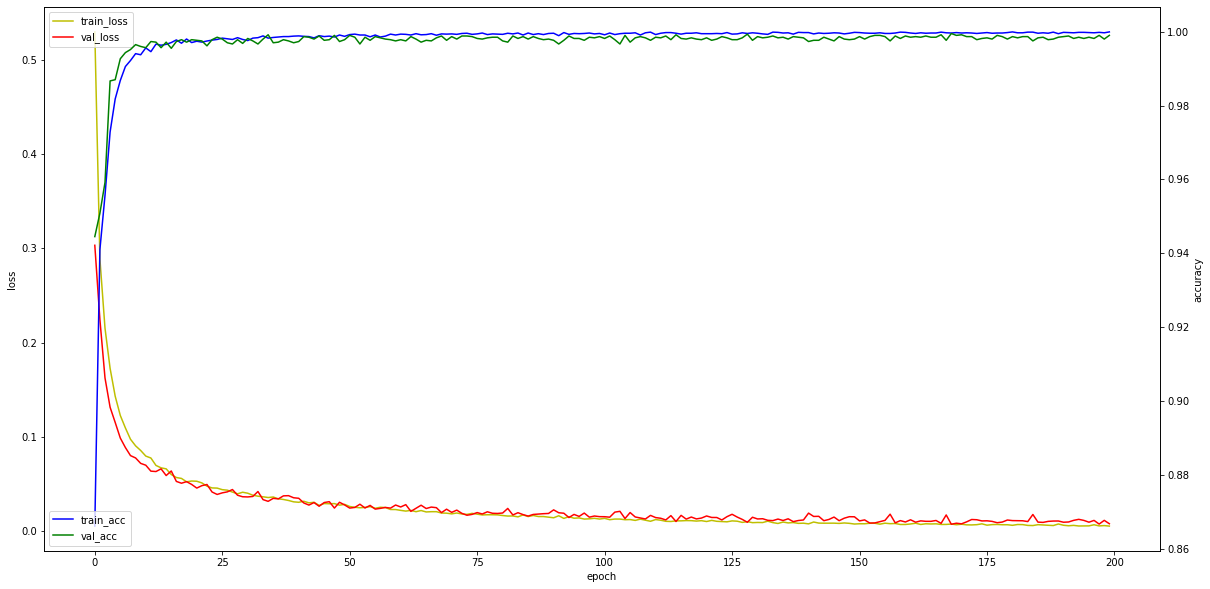

In [21]:
import matplotlib.pyplot as plt
fig, loss_ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(20)
acc_ax = loss_ax.twinx()
loss_ax.plot(history.history['loss'], 'y', label='train_loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val_loss')

acc_ax.plot(history.history['acc'], 'b', label='train_acc')
acc_ax.plot(history.history['val_acc'], 'g', label='val_acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')
loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

In [231]:
data_gen_train = pad_sequences(tidf_gen_train, maxlen=genvec_size, padding='pre')
data_cond_train = pad_sequences(tidf_cond_train, maxlen=convec_size, padding='pre')
data_gen_valid = pad_sequences(tidf_gen_valid, maxlen=genvec_size, padding='pre')
data_cond_valid = pad_sequences(tidf_cond_valid, maxlen=convec_size, padding='pre')

In [232]:
*_, train_acc = model.evaluate([data_cond_train, data_gen_train], tidf_label_train)
*_, valid_acc = model.evaluate([data_cond_valid, data_gen_valid], tidf_label_valid)
train_acc, valid_acc, '{:.3f}%'.format(valid_acc / train_acc * 100)

59281/59281 [==============================] - 15s 249us/step


(0.999126922881943, 0.9987179703446298, '99.959%')

In [22]:
data_gen_test = pad_sequences(tidf_gen_test, maxlen=genvec_size, padding='pre')
data_cond_test = pad_sequences(tidf_cond_test, maxlen=convec_size, padding='pre')

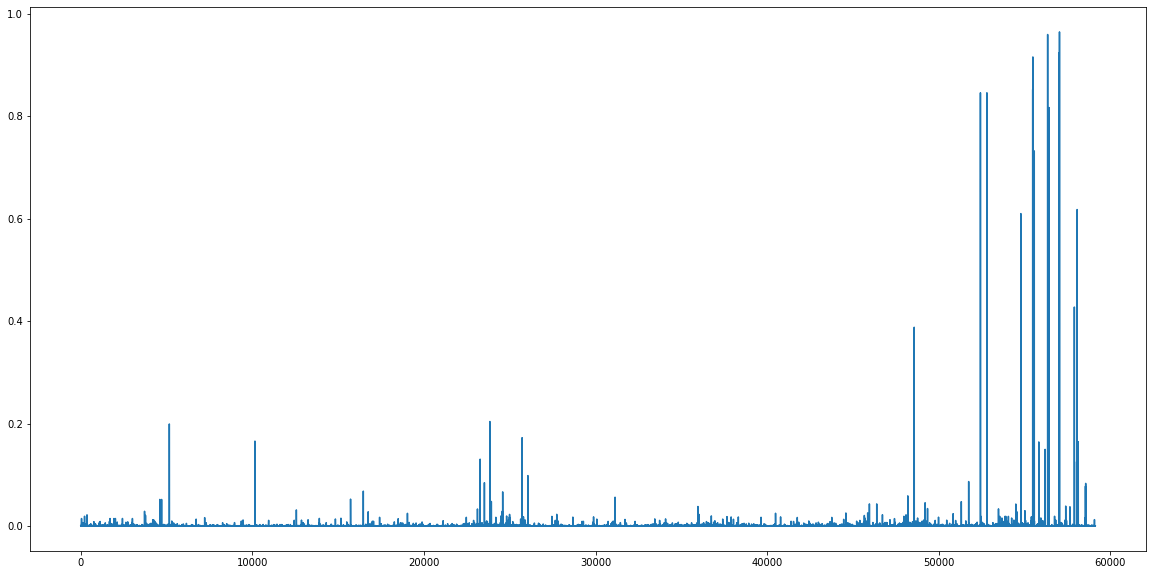

In [23]:
# 결과검증(overfit, underfit)
pred_test = model.predict(x=[data_cond_test, data_gen_test], batch_size=160)
gap = np.abs(tidf_label_test - pred_test.reshape([-1,]))

plt.figure(figsize=(20,10))
plt.plot(gap)

auc : 0.9999874891552156


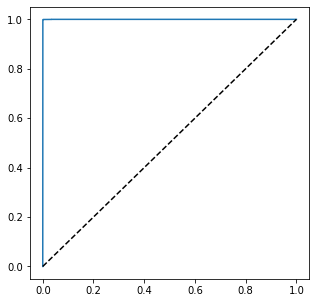

In [241]:
from sklearn.metrics import confusion_matrix, roc_curve
from sklearn.metrics import auc
from matplotlib import pyplot as plt

fpr, tpr, thresholds = roc_curve(tidf_label_test, pred_test)
print('auc :', auc(fpr,tpr))

plt.figure(figsize=(5,5))
plt.plot(fpr,tpr,'-')
plt.plot([0,1],[0,1], 'k--')
plt.show()

In [ ]:
# 제출 준비

In [24]:
submit_df = pd.read_csv('./data/public_test.csv')

In [25]:
unknowns = []

idx = 0
for idx, item in submit_df.iterrows():
    splited = parse_sentence(item.text)
    splited.append(item.id)
    unknowns.append(splited)
    if idx % 100000 == 0:
        print(datetime.now(), idx)
    idx += 1

2019-12-31 11:54:53.695749 0


In [26]:
# smishing cases; length of vocab when it's out of vocab
submit_conditioned = []
submit_general = []

cond_vocabsize = len(conditioned_vocab)
gen_vocabsize = len(general_vocab)

print('size of vocab (conditioned, general):', cond_vocabsize, gen_vocabsize)
for msg in unknowns:
    submit_conditioned.append([conditioned_vocab.get(x) if x in conditioned_vocab else cond_vocabsize for row in msg[:-1] if row[1] == True for x in row[2]])
    submit_general.append([general_vocab.get(x) if x in general_vocab else gen_vocabsize for row in msg[:-1] if row[1] == False for x in row[2]])


size of vocab (conditioned, general): 17073 21749


In [27]:
data_submit_conditioned = pad_sequences(submit_conditioned, maxlen=convec_size, padding='pre')
data_submit_general = pad_sequences(submit_general, maxlen=genvec_size, padding='pre')

In [28]:
pred_y = model.predict(x=[data_submit_conditioned, data_submit_general], verbose=1)

1626/1626 [==============================] - 0s 103us/step


In [29]:
pred_y[pred_y > 1.0] = 1.0

In [30]:
submit_df['smishing'] = np.abs(pred_y)

In [249]:
submit_df[['id', 'smishing']].to_csv('./data/submission_20191230_0.96test.csv', index=False)

In [31]:
submit_df

,id,year_month,text,smishing
0,340000,2019-01,XXX고객님! 안녕하세요? 새롭게 시작하는 한 주 행복 가득하시길 기원합니다. 지난...,0.000157
1,340001,2019-01,긴급 안내 XXX은행 가락동 지점 - 헬리오XXX 기본XXX 대출이자를 ...,0.002653
2,340002,2019-01,XXX 고객님 안녕하세요올해는 미세먼지가 유난인거 같습니다.엊그제 새해가 시작된거같...,0.000079
3,340003,2019-01,XXX 고객님찾아온 행운을 잡으셨나요? 못잡으셨다면 이번에 다시 잡으시길 기원합니다...,0.000092
4,340004,2019-01,XXX 고객님새해 복 많이 받으세요 XXX은행 코스트코 퇴직연금 담당자입니다. 고...,0.000183
...,...,...,...,...
1621,341621,2019-04,(광고)XXX 고객님안녕하십니까!!고객님의 소중한 업무처리를 도와드린 kb창원중앙동...,0.000162
1622,341622,2019-04,고객님 항상 저희 지점을 거래해 주셔서 감사합니다 본점 서비스 설문 전화 받으시면...,0.000090
1623,341623,2019-04,XXX 고객님 저희 XXX은행 XXX지점을 이용해주셔서 감사드립니다 이번주도 더 ...,0.000073
1624,341624,2019-04,(광고)알림 신청하면 매일 현금 100만원! XXX부동산 리브온지금 XXX부동산 리...,0.002719


In [37]:
old_df = pd.read_csv('./data/submission_20191230_1.csv')

In [38]:
compare = old_df.set_index('id') - submit_df[['id', 'smishing']].set_index('id')

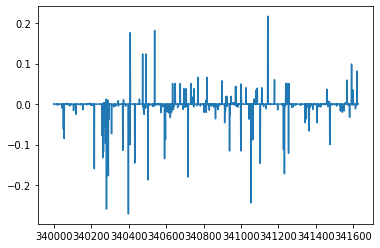

In [39]:
plt.plot(compare)